In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
from io import StringIO

In [78]:
# Load the dataset from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
response = requests.get(url)
data = StringIO(response.text)

# Define column names
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
df = pd.read_csv(data, header=None, names=column_names)



In [79]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          569 non-null    int64  
 1   Diagnosis   569 non-null    object 
 2   Feature_1   569 non-null    float64
 3   Feature_2   569 non-null    float64
 4   Feature_3   569 non-null    float64
 5   Feature_4   569 non-null    float64
 6   Feature_5   569 non-null    float64
 7   Feature_6   569 non-null    float64
 8   Feature_7   569 non-null    float64
 9   Feature_8   569 non-null    float64
 10  Feature_9   569 non-null    float64
 11  Feature_10  569 non-null    float64
 12  Feature_11  569 non-null    float64
 13  Feature_12  569 non-null    float64
 14  Feature_13  569 non-null    float64
 15  Feature_14  569 non-null    float64
 16  Feature_15  569 non-null    float64
 17  Feature_16  569 non-null    float64
 18  Feature_17  569 non-null    float64
 19  Feature_18  569 non-null    f

In [80]:
cl_distribution=df['Diagnosis'].value_counts() 
print(cl_distribution)

Diagnosis
B    357
M    212
Name: count, dtype: int64


Before tuning our models, we first need to determine the most appropriate evaluation metric. Given that our dataset is imbalanced, we must select a metric that effectively accounts for class distribution while ensuring meaningful model evaluation.

We considered the following three metrics:

Recall – This metric focuses on minimizing false negatives, which is crucial in our case. A false negative means predicting benign when the actual diagnosis is malignant, which is an important concern.
Kappa Statistic – While Kappa performs well on imbalanced datasets, it does not account for false positives and false negatives, both of which are critical for our problem. Hence, Kappa is not the best choice.
Matthews Correlation Coefficient (MCC) – MCC is the ideal metric as it performs well on imbalanced datasets and considers all confusion matrix components, including false positives and false negatives, making it a comprehensive evaluation measure.
Based on this analysis, we will use MCC to tune our models and guide our final predictions.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply StandardScaler (fit on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data (do NOT fit again!)

# Print shapes to confirm split
print(f"Training set shape: {X_train_scaled.shape}, Test set shape: {X_test_scaled.shape}")

Training set shape: (455, 30), Test set shape: (114, 30)


In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load your dataset (assuming df is already loaded

# Define models and hyperparameter grids
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {"max_depth": [3, 5, 10, None], "criterion": ["gini", "entropy"]}),
    "Logistic Regression": (LogisticRegression(random_state=42, max_iter=1000), {"C": [0.1, 1, 10, 100]}),
    "SVM": (SVC(random_state=42), {"C": [0.1, 1, 10, 100], "kernel": ["linear", "rbf"]})
}

# Set up nested cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Inner loop for hyperparameter tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Outer loop for model evaluation

# Perform Nested CV
results = {}
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="accuracy", n_jobs=-1)
    nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring="accuracy")
    
    results[name] = {"Mean Accuracy": np.mean(nested_scores), "Std Dev": np.std(nested_scores)}

# Print results
for model, score in results.items():
    print(f"{model}: Mean Accuracy = {score['Mean Accuracy']:.4f}, Std Dev = {score['Std Dev']:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

KNN: Mean Accuracy = 0.9407, Std Dev = 0.0266
Decision Tree: Mean Accuracy = 0.9297, Std Dev = 0.0226
Logistic Regression: Mean Accuracy = 0.9692, Std Dev = 0.0128
SVM: Mean Accuracy = 0.9670, Std Dev = 0.0120


In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, make_scorer
from sklearn.preprocessing import StandardScaler

# Define models and improved hyperparameter grids
models = {
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7, 9, 11, 15],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # Manhattan (p=1) and Euclidean (p=2)
    }),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {
        "max_depth": [3, 5, 10, 20, None],
        "criterion": ["gini", "entropy"],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5]
    }),
    "Logistic Regression": (LogisticRegression(random_state=42, max_iter=10000, solver='liblinear'), {
        "C": [0.01, 0.1, 1, 10, 100, 1000, 10000],  # Expanded range for C
        "solver": ["liblinear", "saga"],  # Different solvers
        "class_weight": [None, "balanced"]  # Add class weight balancing
    }),
    "SVM": (SVC(random_state=42), {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"]
    })
}

# Set up nested cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Inner CV for hyperparameter tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Outer CV for model selection

# Define recall as the evaluation metric
recall_scorer = make_scorer(recall_score)

# Nested cross-validation
results = {}
for name, (model, param_grid) in models.items():
    recall_scores = []  # Store recall scores for each fold

    # Outer CV loop (for model evaluation)
    for train_idx, val_idx in outer_cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Feature scaling inside the CV
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)  # Fit and transform on training data
        X_val_scaled = scaler.transform(X_val_fold)  # Only transform validation data
        
        # Hyperparameter tuning inside inner CV
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring=recall_scorer, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train_fold)
        
        # Get best model and evaluate on outer fold
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val_scaled)
        recall_score_val = recall_score(y_val_fold, y_pred)
        recall_scores.append(recall_score_val)

    # Store results
    results[name] = {"Mean Recall": np.mean(recall_scores), "Std Dev": np.std(recall_scores)}

# Output results
for model, score in results.items():
    print(f"{model}: Mean Recall = {score['Mean Recall']:.4f}, Std Dev = {score['Std Dev']:.4f}")

# Final training with best model on entire training data
best_model_name = max(results, key=lambda x: results[x]["Mean Recall"])
best_model, best_params = models[best_model_name]

# Grid search on entire training data
final_grid_search = GridSearchCV(best_model, best_params, cv=inner_cv, scoring=recall_scorer, n_jobs=-1)
final_grid_search.fit(X_train, y_train)

final_best_model = final_grid_search.best_estimator_

# Scaling the entire training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate final model on the test set
y_test_pred = final_best_model.predict(X_test_scaled)
final_recall = recall_score(y_test, y_test_pred)

print(f"Final Model Recall on Test Set: {final_recall:.4f}")

KNN: Mean Recall = 0.9294, Std Dev = 0.0399
Decision Tree: Mean Recall = 0.8706, Std Dev = 0.0758
Logistic Regression: Mean Recall = 0.9529, Std Dev = 0.0144
SVM: Mean Recall = 0.9412, Std Dev = 0.0263
Final Model Recall on Test Set: 0.7619


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

# Define hyperparameter grid for Logistic Regression
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000, 10000],  # Expanded range for C
    "solver": ["liblinear", "saga"],  # Different solvers
    "class_weight": [None, "balanced"]  # Add class weight balancing
}

# Grid search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42), 
                           param_grid, 
                           cv=5, 
                           scoring='recall',  # Use recall as the evaluation metric
                           n_jobs=-1)

# Fit grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_logistic_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_logistic_model.predict(X_test_scaled)
final_recall = recall_score(y_test, y_test_pred)

print(f"Best Logistic Regression Recall on Test Set: {final_recall:.4f}")
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Logistic Regression Recall on Test Set: 0.9524
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'solver': 'saga'}


Recall on Holdout Test Set: 0.9524


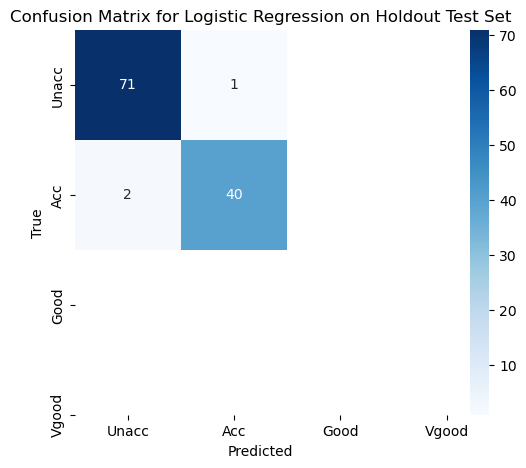

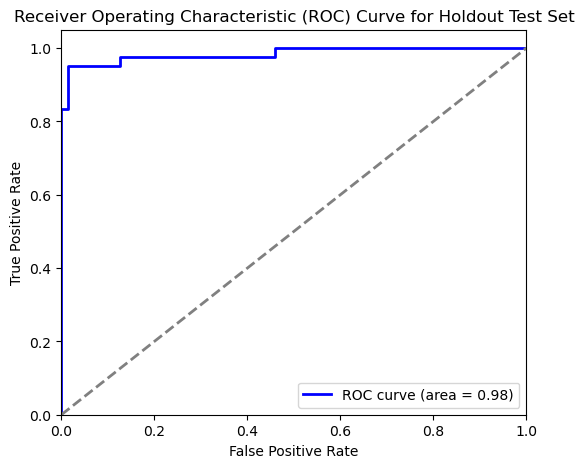

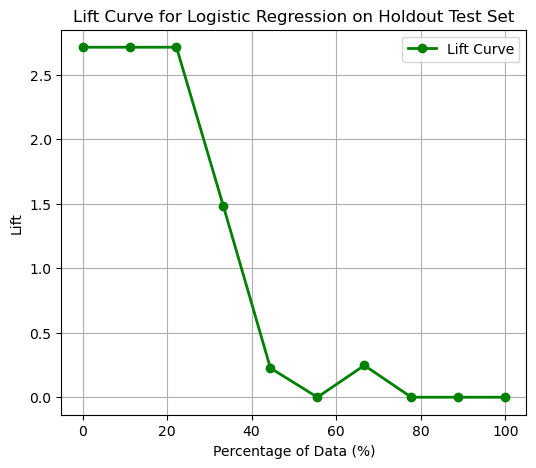

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Assuming best_logistic_model is already trained
# Apply the same scaling to the holdout set
X_holdout_scaled = scaler.transform(X_holdout)

# Predict probabilities on holdout test set
y_holdout_prob = best_logistic_model.predict_proba(X_holdout_scaled)[:, 1]

# Calculate Recall on Holdout Test Set
y_holdout_pred = best_logistic_model.predict(X_holdout_scaled)
final_recall_holdout = recall_score(y_holdout, y_holdout_pred)
print(f"Recall on Holdout Test Set: {final_recall_holdout:.4f}")

# Generate Confusion Matrix for Holdout Set
cm = confusion_matrix(y_holdout, y_holdout_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Unacc", "Acc", "Good", "Vgood"], 
            yticklabels=["Unacc", "Acc", "Good", "Vgood"])
plt.title("Confusion Matrix for Logistic Regression on Holdout Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_holdout, y_holdout_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Holdout Test Set')
plt.legend(loc="lower right")
plt.show()

## Lift Curve Calculation
# Sort the predicted probabilities in descending order
sorted_idx = np.argsort(y_holdout_prob)[::-1]
y_sorted_true = y_holdout.iloc[sorted_idx]  # Use iloc to index by position
y_sorted_prob = y_holdout_prob[sorted_idx]

# Calculate the lift at each decile
deciles = np.linspace(0, len(y_sorted_true), 11).astype(int)
lift_values = []

for i in range(1, len(deciles)):
    # Get the indices for the current decile
    start_idx, end_idx = deciles[i-1], deciles[i]
    decile_true = y_sorted_true[start_idx:end_idx]
    
    # Calculate lift: the ratio of true positives in the decile to the expected true positives if randomly selected
    lift = np.sum(decile_true) / (len(decile_true) * np.mean(y_holdout))
    lift_values.append(lift)

# Plot Lift Curve
plt.figure(figsize=(6, 5))
plt.plot(np.linspace(0, 100, 10), lift_values, color='green', lw=2, marker='o', label="Lift Curve")
plt.xlabel('Percentage of Data (%)')
plt.ylabel('Lift')
plt.title('Lift Curve for Logistic Regression on Holdout Test Set')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

